Beginning of our project :)

Reading our Dataset Below:

In [68]:
#import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score # better metric due to small frequence of date for few types
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [ ]:
MB_dataset = pd.read_csv('mbti_1.csv')
print(MB_dataset)
MB_dataset.describe()


In [ ]:
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
MB_dataset.head()

<AxesSubplot: >

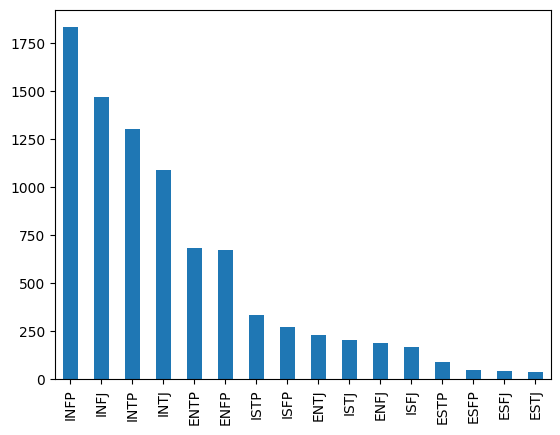

In [78]:
#make a bar chart of how often each personality type is mentioned in a post
MB_dataset["type"].value_counts()
MB_dataset["type"].value_counts().plot(kind="bar")

In [39]:
cnt = MB_dataset.groupby(['type'])['posts'].count()
pie = go.Pie(labels=cnt.index, values=cnt.values)
fig = go.Figure(data=[pie])
py.iplot(fig)

In [43]:
def replace_symbols(text):
    text = re.sub('\|\|\|', ' ', text)
    text = re.sub('https?\S+', '<URL>', text)
    return text

MB_dataset['cleaned_posts'] = MB_dataset['posts'].apply(replace_symbols)

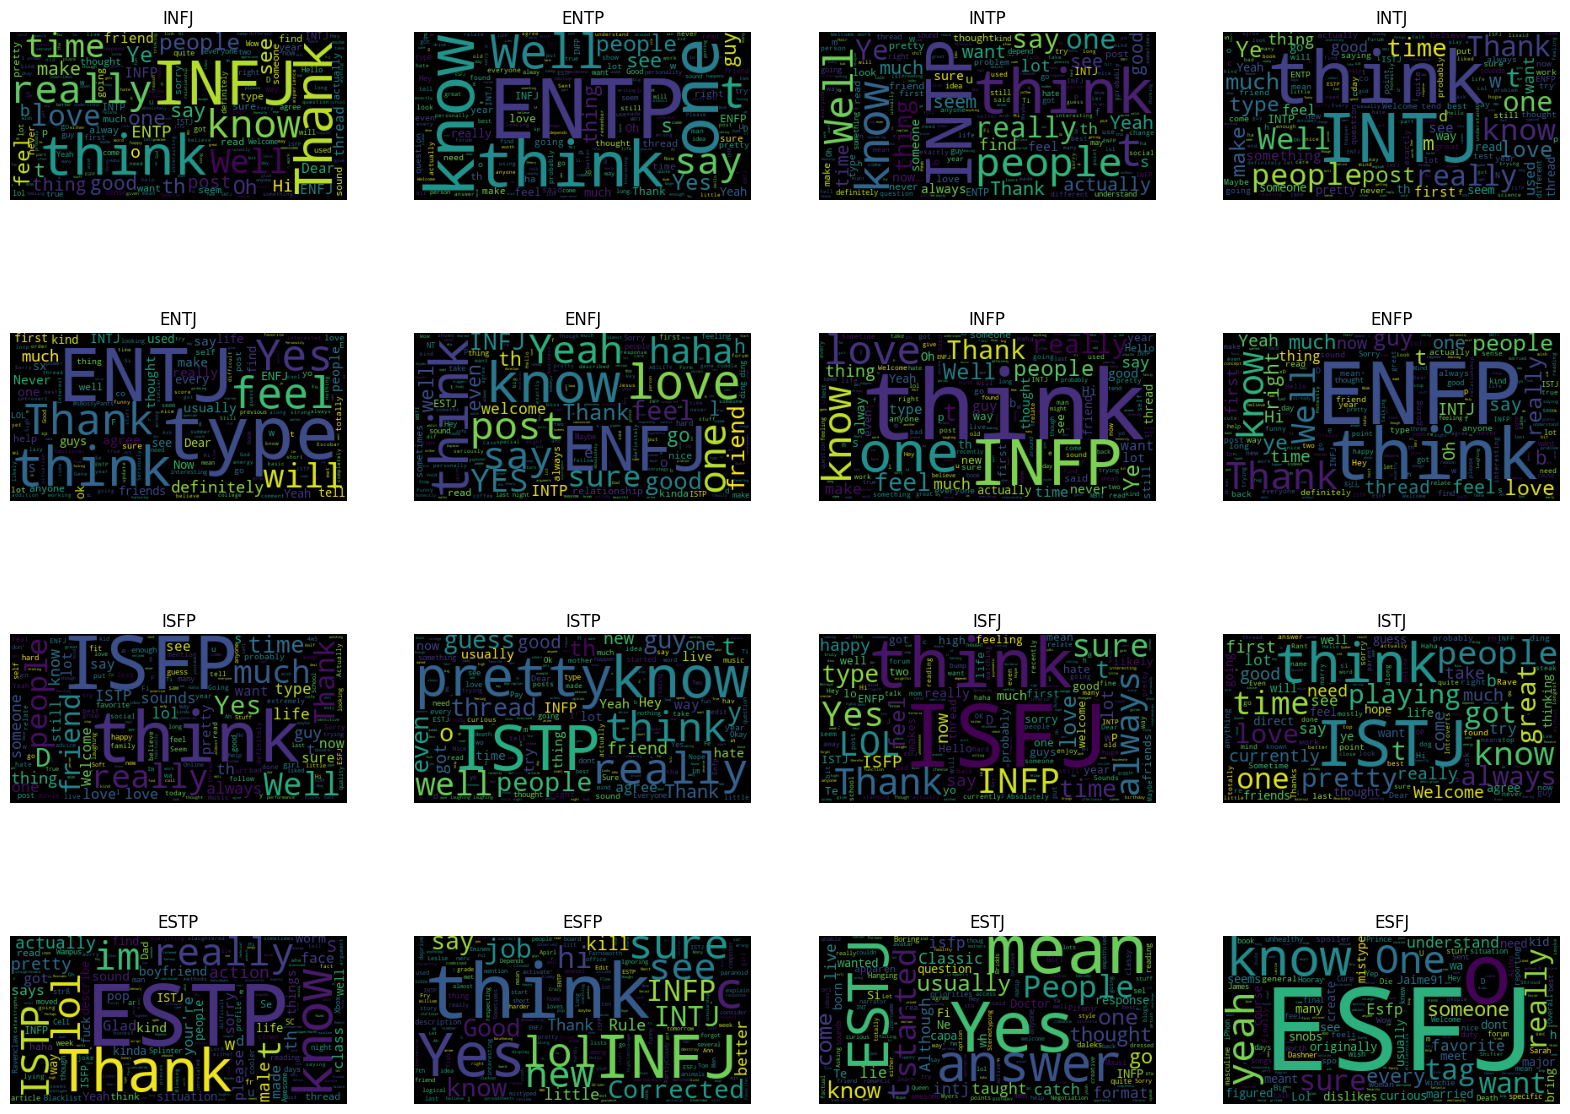

In [47]:
STOPWORDS.add('URL') # words to not consider
labels = MB_dataset['type'].unique()
row, col = 4, 4
wc = WordCloud(stopwords=STOPWORDS)

fig, ax = plt.subplots(4, 4, figsize=(20,15))

for i in range(4):
    for j in range(4):
        cur_type = labels[i*col+j]
        cur_ax = ax[i][j]
        df = MB_dataset[MB_dataset['type'] == cur_type]
        wordcloud = wc.generate(df['cleaned_posts'].to_string())
        cur_ax.imshow(wordcloud)
        cur_ax.axis('off')
        cur_ax.set_title(cur_type)

In [50]:
type_enc = LabelEncoder()
type_enc.fit(MB_dataset['type'])
type_enc.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [58]:
nlp = spacy.load('en_core_web_sm')

In [59]:
def tokenizer(text): # slowed the traning heavily
    doc = nlp(text)
    # preprocess during tokenizing
    tokens = [token.lemma_ for token in doc 
              if not (token.is_stop or token.is_digit or token.is_quote or token.is_space
                     or token.is_punct or token.is_bracket)]    
    return tokens

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

In [60]:
clf = LogisticRegression()

pipe_lr = Pipeline([('tfidf', tfidf), ('lgr', clf)])

In [61]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [66]:
scoring = {'acc': 'accuracy', 'f1': 'f1_micro'}
result = cross_validate(pipe_lr, MB_dataset['cleaned_posts'], type_enc.transform(MB_dataset['type']), scoring=scoring,
                        cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.6s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


In [69]:
print('Logistic regression model performance:')
pprint(result)

for key in result:
    print(key + ' : ', result[key].mean())

Logistic regression model performance:
{'fit_time': array([23.35048676, 22.96528816, 22.48533583, 22.34395313, 23.41568375]),
 'score_time': array([2.02724028, 2.05768251, 2.07888341, 2.20800424, 2.22601223]),
 'test_acc': array([0.65763689, 0.6443804 , 0.67262248, 0.64668588, 0.65417867]),
 'test_f1': array([0.65763689, 0.6443804 , 0.67262248, 0.64668588, 0.65417867])}
fit_time :  22.912149524688722
score_time :  2.1195645332336426
test_acc :  0.6551008645533141
test_f1 :  0.6551008645533141


In [70]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=20)

pipe_rf = Pipeline([('tfidf', tfidf), ('rf', clf)])

In [5]:
MB_dataset = pd.read_csv('mbti_1.csv')
print(MB_dataset)
MB_dataset.describe()
MB_dataset.isnull().sum()

Random forest model performance:
{'fit_time': array([44.75717783, 44.27587152, 44.36576486, 43.7992177 , 44.01392412]),
 'score_time': array([2.29077387, 2.32740116, 2.57224965, 2.55155325, 2.40459466]),
 'test_acc': array([0.52680115, 0.52391931, 0.55504323, 0.53832853, 0.54063401]),
 'test_f1': array([0.52680115, 0.52391931, 0.55504323, 0.53832853, 0.54063401])}
fit_time :  44.242391204833986
score_time :  2.4293145179748534
test_acc :  0.5369452449567723
test_f1 :  0.5369452449567723


type     0
posts    0
dtype: int64

In [6]:
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
MB_dataset.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


<AxesSubplot: >

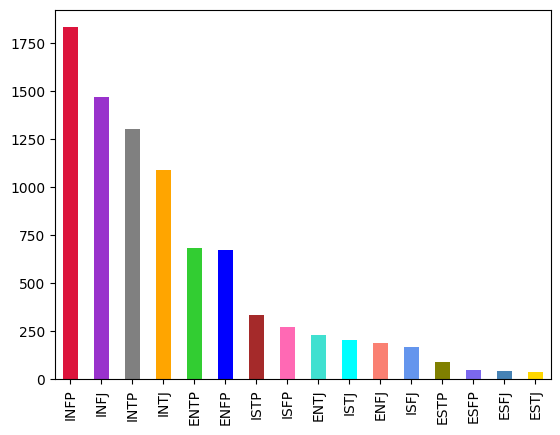

In [7]:
#make a bar chart of how often each personality type is mentioned in a post
MB_dataset["type"].value_counts()
colors = ['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold']

MB_dataset["type"].value_counts().plot(kind="bar", color=['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold' ])


In [8]:
cnt = MB_dataset.groupby(['type'])['posts'].count()
pie = go.Pie(labels=cnt.index, values=cnt.values)
fig = go.Figure(data=[pie])
py.iplot(fig)

In [9]:
df_bar_chart=MB_dataset.groupby('type').count()


trace1 = go.Bar(x=df_bar_chart.index, y=df_bar_chart['posts'])

data = [trace1]
layout = go.Layout(title='MBTI # Classified Posts per Type')

fig = go.Figure(data=data, layout=layout)

fig.show()

In [10]:
type_enc = LabelEncoder()
type_enc.fit(MB_dataset['type'])
type_enc.classes_
MB_dataset.head

<bound method NDFrame.head of       type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]>

In [11]:
lemmatiser = WordNetLemmatizer()
useless_words = stopwords.words("english")


In [27]:
def replace_symbols(text):
    text = re.sub('https?\S+', ' ', text) #Removing urls 
    text = re.sub("[^a-zA-Z]", " ", text) #Removing non-words
    text = re.sub(' +', ' ', text) #Removing consecutive whitespace
    text = " ".join([lemmatiser.lemmatize(w) for w in text.split(' ') if w not in useless_words])
    text = text.lower()
    pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    pers_types = [p.lower() for p in pers_types]
    for t in pers_types:
        text = text.replace(t, "")
    p = re.compile("(" + "|".join(pers_types) + ")")
    return text

MB_dataset['cleaned_posts'] = MB_dataset['posts'].apply(replace_symbols)
MB_dataset.describe()
MB_dataset.head(10)


,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed conversation day esoteric gab...
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,science perfect no scientist claim scientific...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",no i draw nail haha those done professional n...
7,INTJ,'I tend to build up a collection of things on ...,i tend build collection thing desktop use fre...
8,INFJ,"I'm not sure, that's a good question. The dist...",i sure good question the distinction two depen...
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,position i actually let go person due various...


In [28]:
print("\nPost before preprocessing:\n\n", MB_dataset['posts'][0])



Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010

In [29]:
print("\nPost after preprocessing:\n\n", MB_dataset['cleaned_posts'][0])



Post after preprocessing:

   moment sportscenter top ten play prank what life changing experience life on repeat today may perc experience immerse the last thing  friend posted facebook committing suicide next day rest peace  sorry hear distress it natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg i mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left all thing moderation sims indeed video game good one note good one somewhat subjective i completely promoting death given sim dear  what favorite video game growing current favorite video game cool appears late sad there someone everyone wait i thought confidence good thing i cherish time solitude b c revel within inner world whereas time workin enjoy time don worry

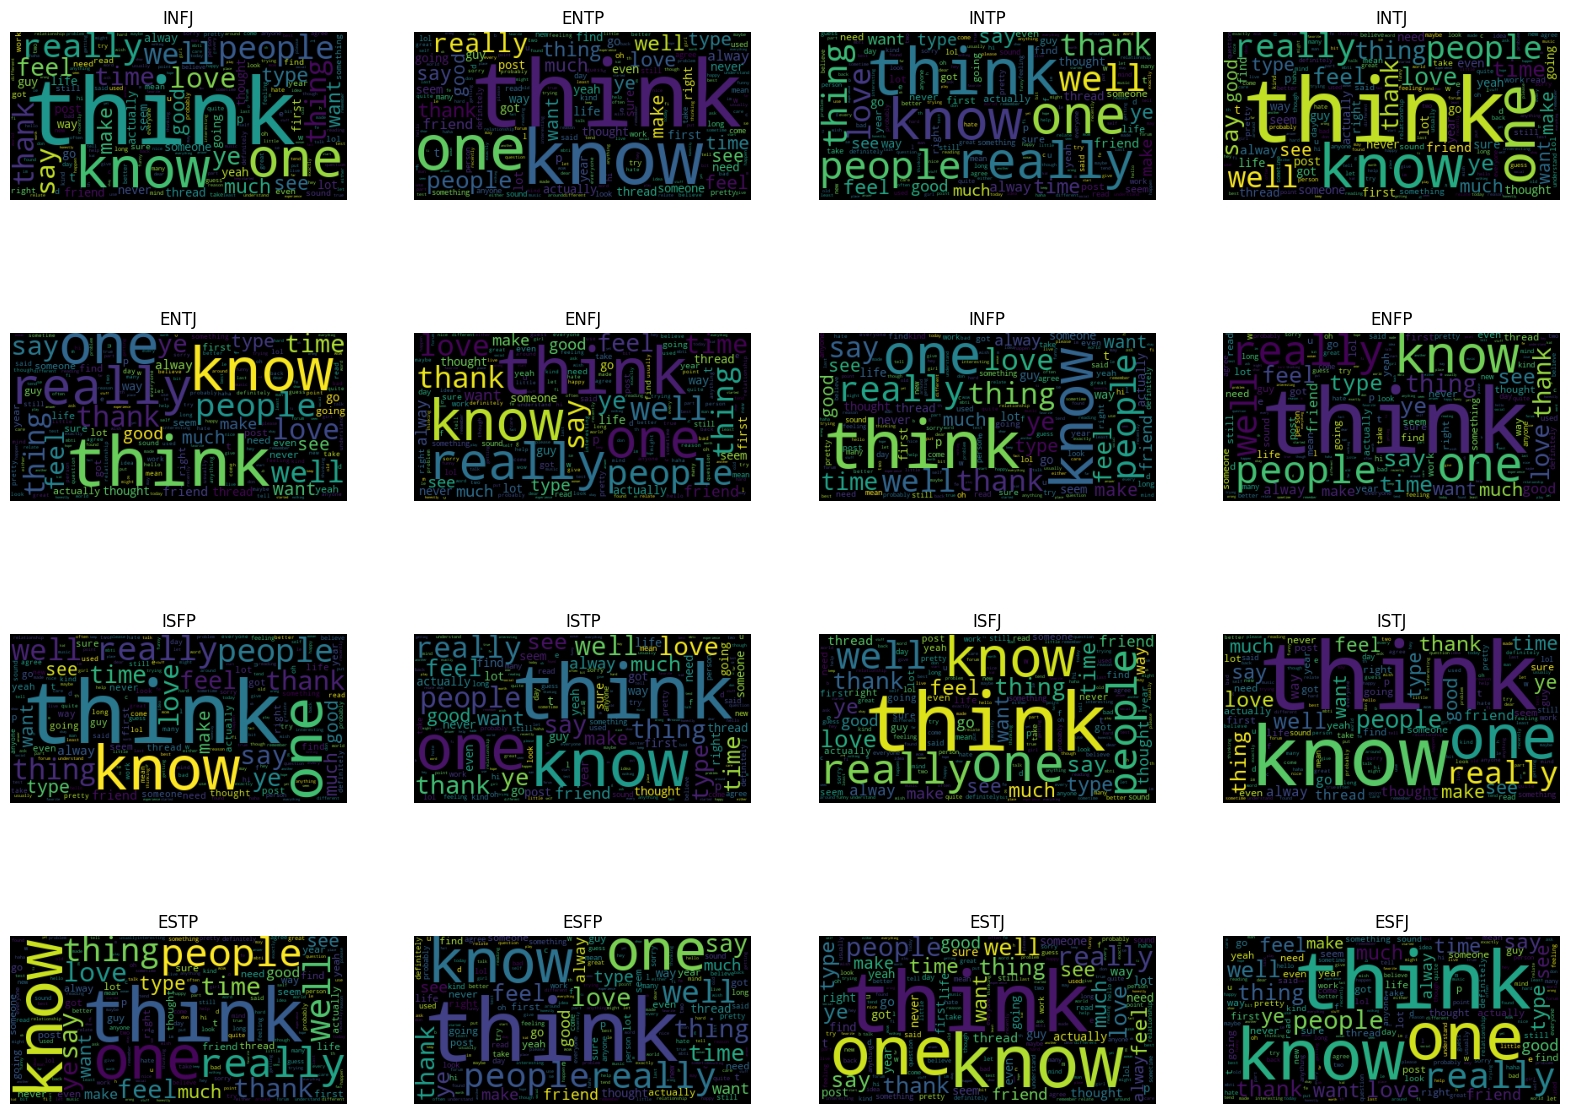

In [31]:
STOPWORDS.add('URL') # words to not consider
STOPWORDS.add('S')
labels = MB_dataset['type'].unique()
row, col = 4, 4
wc = WordCloud(stopwords=STOPWORDS)

fig, ax = plt.subplots(4, 4, figsize=(20,15))

for i in range(4):
    for j in range(4):
        cur_type = labels[i*col+j]
        cur_ax = ax[i][j]
        df = MB_dataset[MB_dataset['type'] == cur_type]
        wordcloud = wc.generate(MB_dataset['cleaned_posts'].to_string())
        cur_ax.imshow(wordcloud)
        cur_ax.axis('off')
        cur_ax.set_title(cur_type)

In [16]:
sw = MB_dataset.copy()

sw['words_per_comment'] = sw['cleaned_posts'].apply(lambda x: len(x.split())/50)
sw.head()

,type,posts,cleaned_posts,words_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten plays p...,10.70
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,23.04
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know thats my...,16.32
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed our conversation the other day...,20.84
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...,19.18


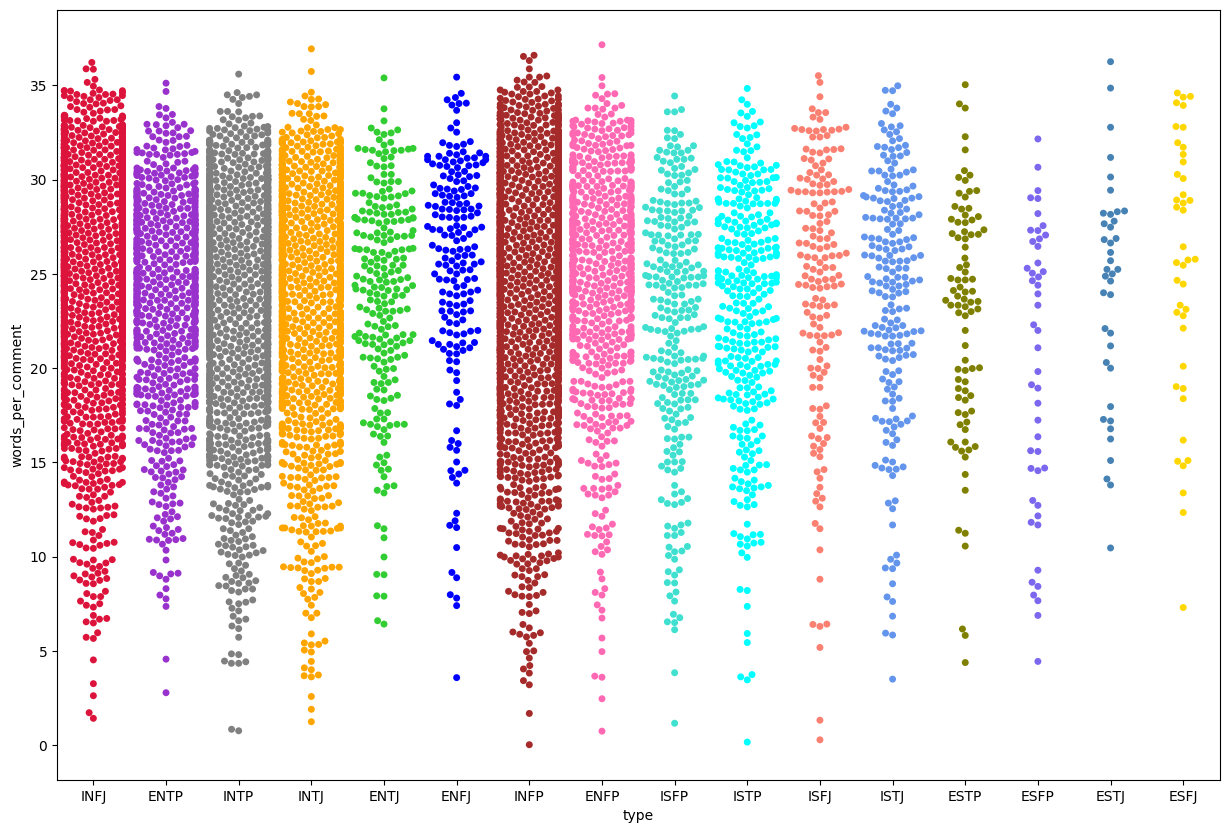

In [17]:
plt.figure(figsize=(15,10))
sns.swarmplot(data=sw, x="type", y="words_per_comment", palette = colors)
plt.show()

Binarizing target feature labels (types)

In [38]:
#b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
#def translate_personality(personality):
    # transform mbti to binary vector
#    return [b_Pers[l] for l in personality]
#for i in range (len(sw))
#    sw['type'][i] = translate_personality(sw['type'][i])
#sw.head

In [ ]:
print(bin)

Data splitting

In [18]:
X = df['cleaned_posts'] # features
y = df['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)